# **Homework 5 - Sequence-to-sequence**

If you have any questions, feel free to email us at: ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates)
1. Link to tutorial video [part 1](https://youtu.be/1pjS5_L5REI) [part 2](https://youtu.be/3XX9d0ymKgQ).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [117]:
#!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
#!pip install --upgrade jupyter ipywidgets

In [118]:
#!git clone https://github.com/pytorch/fairseq.git
#!cd fairseq && git checkout 9a1c497
#!pip install --upgrade ./fairseq/

In [119]:
#!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

In [120]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [121]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset Information

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

# Dataset Download

## Install megatools (optional)

In [122]:
#!apt-get install megatools

## Download and extract

In [123]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"',
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead.
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead.
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

#prefix.mkdir(parents=True, exist_ok=True)
#for u, f in zip(urls, file_names):
#    path = prefix/f
#    if not path.exists():
#        if 'mega' in u:
#            !megadl {u} --path {path}
#        else:
#            !wget {u} -O {path}
#    if path.suffix == ".tgz":
#        !tar -xvf {path} -C {prefix}
#    elif path.suffix == ".zip":
#        !unzip -o {path} -d {prefix}
#!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
#!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
#!mv {prefix/'test.en'} {prefix/'test.raw.en'}
#!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

## Language

In [124]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [125]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [126]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [127]:
clean_corpus(data_prefix, src_lang, tgt_lang)
# clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.


In [128]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [129]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [130]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [131]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [132]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
}
for split in ['train', 'valid']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/mnt/e/Workspace/NSYSU/Lab/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [133]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁opportunity ▁to ▁come ▁to ▁this ▁stage ▁ t wi ce ▁; ▁i ' m ▁extreme ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con f er ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感謝 大家 對 我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [134]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for Experiments

In [135]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",

    # cpu threads when fetching & processing data.
    num_workers=2,
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,

    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,

    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,

    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,

    # beam size for beam search
    beam=5,
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2,
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",

    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)

    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [136]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environment

In [137]:
#cuda_env = utils.CudaEnvironment()
#utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# get devices
gpuIdx = 0
deviceGPU = torch.device(f"cuda:{gpuIdx}")
deviceCPU = torch.device("cpu:0")

device = deviceCPU
if torch.cuda.is_available():
    device = deviceGPU
    print(f"Using cuda with device-{gpuIdx} ({torch.cuda.get_device_name(gpuIdx)})")
else:
    cpuName = subprocess.check_output(["wmic","cpu","get", "name"]).decode("utf8").strip().split("\n")[1]
    print(f"Using CPU ({cpuName})")

Using cuda with device-0 (NVIDIA GeForce RTX 3070)


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [138]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2024-07-19 16:02:48 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2024-07-19 16:02:48 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [139]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2024-07-19 16:02:48 | INFO | hw5.seq2seq | loading data for epoch 1
2024-07-19 16:02:48 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2024-07-19 16:02:48 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2024-07-19 16:02:48 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2024-07-19 16:02:48 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2024-07-19 16:02:48 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2024-07-19 16:02:48 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [140]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  56,   32,   26,  113, 2234,  114,   84,  157,    7,   22,  855,   86,
           7,    2]),
 'target': tensor([ 313,  432,  381, 3573,    4,   50,  147, 2412,  272,    2])}
'Source: but this is our front porch . we live there .'
'Target: 這是我們的前庭 , 我們就住在那'


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens):
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [141]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond
        # first call of this method has no effect.
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2024-07-19 16:02:49 | WARNING | fairseq.tasks.fairseq_task | 2,583 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[329, 743, 3501, 2681, 3687, 740, 3068, 3532, 2760, 3262]


{'id': tensor([1073]),
 'nsentences': 1,
 'ntokens': 15,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,   56,   20,   26,  103,    5,  319,
             24,   71,  244,   23, 1018,  808, 1734,   40,    9, 1293,    7,    2]]),
  'src_lengths': tensor([18]),
  'prev_output_tokens': tensor([[   2,    5, 1376, 1339, 1086,    4, 2829,   48,  296, 2596, 1833,    8,
           2408, 2054,   10,    1]])},
 'target': tensor([[   5, 1376, 1339, 1086,    4, 2829,   48,  296, 2596, 1833,    8, 2408,
          2054,   10,    2,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [142]:
from fairseq.models import (
    FairseqEncoder,
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask.
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs:
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2
- Outputs:
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [143]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers

        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)

        self.padding_idx = dictionary.pad()

    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()

        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]

        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]

        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )

    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs:
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs:
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [144]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B

        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S

        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh

        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs:
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs:
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [145]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens

        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""

        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers


        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        )
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)

        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None

        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )

    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch

        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens

        bsz, seqlen = prev_output_tokens.size()

        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)

        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)

        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)

        # project to embedding size (if hidden differs from embed size, and share_embedding is True,
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)

        # project to vocab size
        x = self.output_projection(x)

        # T x B x C -> B x T x C
        x = x.transpose(1, 0)

        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)

        return x, None

    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder**
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [146]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args

    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [147]:
# # HINT: transformer architecture
from fairseq.models.transformer import TransformerEncoder,TransformerDecoder

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)

    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)

    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [148]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True

    args.decoder_attention_heads=4
    args.decoder_normalize_before=True

    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024

    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [149]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [150]:
model = build_model(arch_args, task)
logger.info(model)

2024-07-19 16:02:49 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayerBase(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_feature

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [151]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce

    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy,
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [152]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

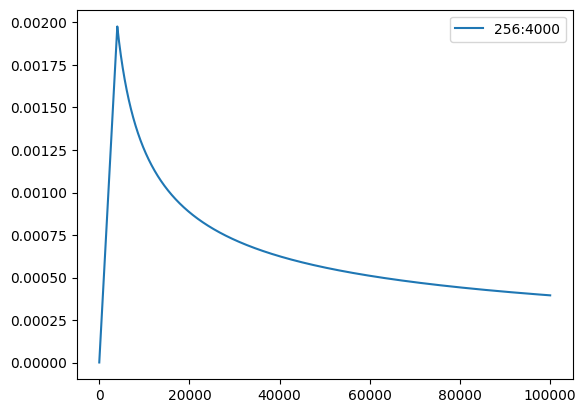

In [153]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim,
    factor=config.lr_factor,
    warmup=config.lr_warmup,
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [154]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples

    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp)

    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i

            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))

                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding

        scaler.step(optimizer)
        scaler.update()

        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })

    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [155]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()),
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()),
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [156]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)

            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)

    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs

    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)

    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])

    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [157]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)

        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")

        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")

        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()

    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [158]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [159]:
!nvidia-smi

Fri Jul 19 16:02:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76.01              Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070        On  |   00000000:0B:00.0 Off |                  N/A |
|  0%   52C    P8             19W /  220W |    4592MiB /   8192MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [160]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2024-07-19 16:02:49 | INFO | hw5.seq2seq | task: TranslationTask
2024-07-19 16:02:49 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2024-07-19 16:02:49 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2024-07-19 16:02:49 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2024-07-19 16:02:49 | INFO | hw5.seq2seq | optimizer: NoamOpt
2024-07-19 16:02:49 | INFO | hw5.seq2seq | num. model params: 14,620,672 (num. trained: 14,620,672)
2024-07-19 16:02:49 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [161]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
# try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2024-07-19 16:02:49 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326662]
2024-07-19 16:02:50 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 1:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:05:00 | INFO | hw5.seq2seq | training loss: 7.0223
2024-07-19 16:05:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:05:26 | INFO | hw5.seq2seq | example source: do you also feel that now , fellow citizen ?
2024-07-19 16:05:26 | INFO | hw5.seq2seq | example hypothesis: 所以 , 不不想 , 這樣 ?
2024-07-19 16:05:26 | INFO | hw5.seq2seq | example reference: 你們現在也感受到那種感覺嗎 , 同胞們 ?
2024-07-19 16:05:26 | INFO | hw5.seq2seq | validation loss:	5.9422
2024-07-19 16:05:26 | INFO | hw5.seq2seq | BLEU = 1.04 16.3/2.5/0.5/0.1 (BP = 0.878 ratio = 0.885 hyp_len = 98524 ref_len = 111296)
2024-07-19 16:05:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint1.pt
2024-07-19 16:05:54 | INFO | hw5.seq2seq | end of epoch 1
2024-07-19 16:05:54 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 2:   0%|          | 0/797 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767cd8dc10>
Traceback (most recent call last):
  File "/root/anaconda3/envs/ML2021-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/root/anaconda3/envs/ML2021-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/root/anaconda3/envs/ML2021-env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f767cd8dc10>
Traceback (most recent call last):
  File "/root/anaconda3/envs/ML2021-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/root/anaconda3/envs/ML2021-env/lib/python3.9/site-packag

validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:08:29 | INFO | hw5.seq2seq | example source: this is big . this was huge .
2024-07-19 16:08:29 | INFO | hw5.seq2seq | example hypothesis: 這是很大的 。
2024-07-19 16:08:29 | INFO | hw5.seq2seq | example reference: 這是件大事 , 非常大 。
2024-07-19 16:08:29 | INFO | hw5.seq2seq | validation loss:	4.9454
2024-07-19 16:08:29 | INFO | hw5.seq2seq | BLEU = 8.10 37.9/14.5/5.9/2.5 (BP = 0.854 ratio = 0.864 hyp_len = 96110 ref_len = 111296)
2024-07-19 16:08:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint2.pt
2024-07-19 16:08:30 | INFO | hw5.seq2seq | end of epoch 2
2024-07-19 16:08:30 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 3:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:10:42 | INFO | hw5.seq2seq | training loss: 4.8913
2024-07-19 16:10:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:11:05 | INFO | hw5.seq2seq | example source: now b , he's answered " yes . "
2024-07-19 16:11:05 | INFO | hw5.seq2seq | example hypothesis: 嗯 , 他回答了 「 是的 」 。
2024-07-19 16:11:05 | INFO | hw5.seq2seq | example reference: 換b君 , 他回答 「 是 」 ,
2024-07-19 16:11:05 | INFO | hw5.seq2seq | validation loss:	4.5226
2024-07-19 16:11:05 | INFO | hw5.seq2seq | BLEU = 10.81 44.9/19.6/9.4/4.7 (BP = 0.769 ratio = 0.792 hyp_len = 88128 ref_len = 111296)
2024-07-19 16:11:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint3.pt
2024-07-19 16:11:06 | INFO | hw5.seq2seq | end of epoch 3
2024-07-19 16:11:06 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 4:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:13:16 | INFO | hw5.seq2seq | training loss: 4.5924
2024-07-19 16:13:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:13:44 | INFO | hw5.seq2seq | example source: baakir and his partner nicole , with their baby girl strapped to her back , are there in the mix of it all , serving up a cup of coffee , teaching a child how to play mancala , or painting a sign for an upcoming community event .
2024-07-19 16:13:44 | INFO | hw5.seq2seq | example hypothesis: 巴克和他的夥伴和他的夥伴 , 和他們的嬰兒們一起坐著她回來 , 在那裡 , 教孩子們 , 教孩子們 , 教孩子們如何玩笑 , 教孩子如何扮演社群 , 或在社群的社區裡扮演社區 , 甚至是如何扮演社區 。
2024-07-19 16:13:44 | INFO | hw5.seq2seq | example reference: 巴基爾和他的另一半妮可背著他們的女兒跟大家混在一起提供咖啡、教小孩玩《播棋》或是為即將舉辦的團體活動描繪標誌
2024-07-19 16:13:44 | INFO | hw5.seq2seq | validation loss:	4.2877
2024-07-19 16:13:44 | INFO | hw5.seq2seq | BLEU = 14.35 43.9/20.4/10.2/5.3 (BP = 0.968 ratio = 0.969 hyp_len = 107813 ref_len = 111296)
2024-07-19 16:13:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint4.pt
2024-07-19 16:13:45 | INFO | hw5.seq2seq | end of epoch 4
2024-07-19 16:13:45 | INFO | fairseq.data.i

train epoch 5:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:15:52 | INFO | hw5.seq2seq | training loss: 4.4201
2024-07-19 16:15:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:16:20 | INFO | hw5.seq2seq | example source: wow ! some of you watched it . that's great . that's great .
2024-07-19 16:16:20 | INFO | hw5.seq2seq | example hypothesis: 哇 ! 有些人看著它 。 這很棒 。 這很棒 。
2024-07-19 16:16:20 | INFO | hw5.seq2seq | example reference: 太好了
2024-07-19 16:16:20 | INFO | hw5.seq2seq | validation loss:	4.1467
2024-07-19 16:16:20 | INFO | hw5.seq2seq | BLEU = 15.21 48.5/23.3/12.0/6.5 (BP = 0.882 ratio = 0.888 hyp_len = 98837 ref_len = 111296)
2024-07-19 16:16:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint5.pt
2024-07-19 16:16:22 | INFO | hw5.seq2seq | end of epoch 5
2024-07-19 16:16:22 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 6:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:18:31 | INFO | hw5.seq2seq | training loss: 4.2673
2024-07-19 16:18:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:18:55 | INFO | hw5.seq2seq | example source: thank you .
2024-07-19 16:18:55 | INFO | hw5.seq2seq | example hypothesis: 多謝 。
2024-07-19 16:18:55 | INFO | hw5.seq2seq | example reference: 謝謝
2024-07-19 16:18:55 | INFO | hw5.seq2seq | validation loss:	3.9816
2024-07-19 16:18:55 | INFO | hw5.seq2seq | BLEU = 16.92 52.0/26.0/13.8/7.7 (BP = 0.868 ratio = 0.876 hyp_len = 97481 ref_len = 111296)
2024-07-19 16:18:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint6.pt
2024-07-19 16:18:56 | INFO | hw5.seq2seq | end of epoch 6
2024-07-19 16:18:56 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 7:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:21:05 | INFO | hw5.seq2seq | training loss: 4.1272
2024-07-19 16:21:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:21:29 | INFO | hw5.seq2seq | example source: thank you .
2024-07-19 16:21:29 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2024-07-19 16:21:29 | INFO | hw5.seq2seq | example reference: 謝謝 。
2024-07-19 16:21:29 | INFO | hw5.seq2seq | validation loss:	3.8901
2024-07-19 16:21:29 | INFO | hw5.seq2seq | BLEU = 18.20 53.2/27.3/14.8/8.3 (BP = 0.885 ratio = 0.891 hyp_len = 99157 ref_len = 111296)
2024-07-19 16:21:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint7.pt
2024-07-19 16:21:31 | INFO | hw5.seq2seq | end of epoch 7
2024-07-19 16:21:31 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 8:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:23:38 | INFO | hw5.seq2seq | training loss: 4.0262
2024-07-19 16:23:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:24:01 | INFO | hw5.seq2seq | example source: and that's the key , perhaps , to reframing our thinking about medicine .
2024-07-19 16:24:01 | INFO | hw5.seq2seq | example hypothesis: 這是關鍵 , 也許 , 要重新思考醫學 。
2024-07-19 16:24:01 | INFO | hw5.seq2seq | example reference: 可能這就是答案 , 改變我們對醫學的想法 。
2024-07-19 16:24:01 | INFO | hw5.seq2seq | validation loss:	3.8255
2024-07-19 16:24:01 | INFO | hw5.seq2seq | BLEU = 18.87 55.2/28.8/15.8/9.1 (BP = 0.862 ratio = 0.871 hyp_len = 96891 ref_len = 111296)
2024-07-19 16:24:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint8.pt
2024-07-19 16:24:02 | INFO | hw5.seq2seq | end of epoch 8
2024-07-19 16:24:02 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 9:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:26:10 | INFO | hw5.seq2seq | training loss: 3.9554
2024-07-19 16:26:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:26:35 | INFO | hw5.seq2seq | example source: and there are several reasons for this .
2024-07-19 16:26:35 | INFO | hw5.seq2seq | example hypothesis: 這對此有許多原因 。
2024-07-19 16:26:35 | INFO | hw5.seq2seq | example reference: 這有幾個原因
2024-07-19 16:26:35 | INFO | hw5.seq2seq | validation loss:	3.7673
2024-07-19 16:26:35 | INFO | hw5.seq2seq | BLEU = 20.25 54.2/28.5/15.8/9.3 (BP = 0.928 ratio = 0.931 hyp_len = 103569 ref_len = 111296)
2024-07-19 16:26:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint9.pt
2024-07-19 16:26:36 | INFO | hw5.seq2seq | end of epoch 9
2024-07-19 16:26:36 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 10:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:28:45 | INFO | hw5.seq2seq | training loss: 3.9012
2024-07-19 16:28:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:29:09 | INFO | hw5.seq2seq | example source: what if we could replace them and all the asphalt that comes with them with drones and robots that could rescue people from burning buildings ?
2024-07-19 16:29:09 | INFO | hw5.seq2seq | example hypothesis: 如果我們能把它們取代 , 所有和他們一起用無人機和機器人來拯救人們 , 能拯救人們的燃燒建築嗎 ?
2024-07-19 16:29:09 | INFO | hw5.seq2seq | example reference: 假如我們能以無人機和機器人來取代消防車和瀝青 , 把人從火場裡救出來呢 ?
2024-07-19 16:29:09 | INFO | hw5.seq2seq | validation loss:	3.7223
2024-07-19 16:29:09 | INFO | hw5.seq2seq | BLEU = 20.59 54.7/29.0/16.2/9.5 (BP = 0.926 ratio = 0.929 hyp_len = 103400 ref_len = 111296)
2024-07-19 16:29:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint10.pt
2024-07-19 16:29:10 | INFO | hw5.seq2seq | end of epoch 10
2024-07-19 16:29:10 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 11:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:31:20 | INFO | hw5.seq2seq | training loss: 3.8581
2024-07-19 16:31:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:31:43 | INFO | hw5.seq2seq | example source: why do none of these places have any of the charming characteristics of our older cities ?
2024-07-19 16:31:43 | INFO | hw5.seq2seq | example hypothesis: 為什麼這些地方沒有任何一個適當的城市 ?
2024-07-19 16:31:43 | INFO | hw5.seq2seq | example reference: 為什麼這些地方都沒有我們老城區的迷人特色 ?
2024-07-19 16:31:43 | INFO | hw5.seq2seq | validation loss:	3.6918
2024-07-19 16:31:43 | INFO | hw5.seq2seq | BLEU = 20.40 56.7/30.4/17.1/10.1 (BP = 0.874 ratio = 0.882 hyp_len = 98116 ref_len = 111296)
2024-07-19 16:31:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint11.pt
2024-07-19 16:31:44 | INFO | hw5.seq2seq | end of epoch 11
2024-07-19 16:31:44 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 12:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:33:53 | INFO | hw5.seq2seq | training loss: 3.8216
2024-07-19 16:33:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:34:20 | INFO | hw5.seq2seq | example source: but could they have predicted this unprecedented spike less than halfway through the earth's life ?
2024-07-19 16:34:20 | INFO | hw5.seq2seq | example hypothesis: 但他們是否能預測這種未預期的藥丸 , 比地球的一半還少 ?
2024-07-19 16:34:20 | INFO | hw5.seq2seq | example reference: 但他們是否曾預測到這在地球壽命不到一半的時點會產生前所未有的生命活動高峰期呢 ?
2024-07-19 16:34:20 | INFO | hw5.seq2seq | validation loss:	3.6752
2024-07-19 16:34:20 | INFO | hw5.seq2seq | BLEU = 21.32 55.1/29.5/16.7/10.0 (BP = 0.934 ratio = 0.936 hyp_len = 104214 ref_len = 111296)
2024-07-19 16:34:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint12.pt
2024-07-19 16:34:21 | INFO | hw5.seq2seq | end of epoch 12
2024-07-19 16:34:21 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 13:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:36:30 | INFO | hw5.seq2seq | training loss: 3.7895
2024-07-19 16:36:30 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:36:52 | INFO | hw5.seq2seq | example source: and as you can see here , they can avoid delicate organs and still reach the targets they're aiming for .
2024-07-19 16:36:52 | INFO | hw5.seq2seq | example hypothesis: 如你所見 , 它們可以避免降低器官 , 還能達到目標 。
2024-07-19 16:36:52 | INFO | hw5.seq2seq | example reference: 如你所見 , 他們可以避開脆弱的器官在需要的地方插針
2024-07-19 16:36:52 | INFO | hw5.seq2seq | validation loss:	3.6447
2024-07-19 16:36:52 | INFO | hw5.seq2seq | BLEU = 21.19 57.2/31.0/17.6/10.5 (BP = 0.887 ratio = 0.893 hyp_len = 99360 ref_len = 111296)
2024-07-19 16:36:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint13.pt
2024-07-19 16:36:53 | INFO | hw5.seq2seq | end of epoch 13
2024-07-19 16:36:53 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 14:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:39:01 | INFO | hw5.seq2seq | training loss: 3.7636
2024-07-19 16:39:01 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:39:24 | INFO | hw5.seq2seq | example source: it was like leaving our mark on society , to say , " i was here , " on the top of a building .
2024-07-19 16:39:24 | INFO | hw5.seq2seq | example hypothesis: 就像離開社會的標誌 , 說: 「 我在這裡 」 , 在建築的頂端 。
2024-07-19 16:39:24 | INFO | hw5.seq2seq | example reference: 就像在社會各處留下我們的印記 , 在城市頂端宣稱: 「 我曾在此 。 」
2024-07-19 16:39:24 | INFO | hw5.seq2seq | validation loss:	3.6249
2024-07-19 16:39:24 | INFO | hw5.seq2seq | BLEU = 21.81 56.4/30.5/17.4/10.4 (BP = 0.924 ratio = 0.927 hyp_len = 103120 ref_len = 111296)
2024-07-19 16:39:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint14.pt
2024-07-19 16:39:26 | INFO | hw5.seq2seq | end of epoch 14
2024-07-19 16:39:26 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 15:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:41:34 | INFO | hw5.seq2seq | training loss: 3.7419
2024-07-19 16:41:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:41:55 | INFO | hw5.seq2seq | example source: remember the last time you tried to move a heavy object across the floor , and you could just feel something resisting you ?
2024-07-19 16:41:55 | INFO | hw5.seq2seq | example hypothesis: 記住你最後一次嘗試在地板上移動重大物體 , 你可以感覺到抗拒你的東西嗎 ?
2024-07-19 16:41:55 | INFO | hw5.seq2seq | example reference: 還記得嘗試挪動地板上的重物時 , 卻感覺受到阻擋嗎 ?
2024-07-19 16:41:55 | INFO | hw5.seq2seq | validation loss:	3.6089
2024-07-19 16:41:55 | INFO | hw5.seq2seq | BLEU = 21.79 57.4/31.3/18.0/10.9 (BP = 0.895 ratio = 0.900 hyp_len = 100137 ref_len = 111296)
2024-07-19 16:41:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint15.pt
2024-07-19 16:41:56 | INFO | hw5.seq2seq | end of epoch 15
2024-07-19 16:41:56 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 16:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:44:05 | INFO | hw5.seq2seq | training loss: 3.7205
2024-07-19 16:44:05 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:44:29 | INFO | hw5.seq2seq | example source: and we all know the perils and the risks that go along with this , but we're doing something that's much bigger than ourselves , and helping advance civilization , so the risk is worth the reward .
2024-07-19 16:44:29 | INFO | hw5.seq2seq | example hypothesis: 我們都知道這些信息和風險 , 但我們在做比自己更大的事 , 幫助進步文明 , 所以風險是值得獎勵的 。
2024-07-19 16:44:29 | INFO | hw5.seq2seq | example reference: 我們都知道這工作的危險和風險 , 但我們在做的事情超越了我們自身 , 協助文明的進步 , 冒這樣的風險是值得的 。
2024-07-19 16:44:29 | INFO | hw5.seq2seq | validation loss:	3.5972
2024-07-19 16:44:29 | INFO | hw5.seq2seq | BLEU = 22.05 57.1/31.2/17.9/10.8 (BP = 0.911 ratio = 0.915 hyp_len = 101837 ref_len = 111296)
2024-07-19 16:44:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint16.pt
2024-07-19 16:44:30 | INFO | hw5.seq2seq | end of epoch 16
2024-07-19 16:44:30 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 17:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:46:40 | INFO | hw5.seq2seq | training loss: 3.7007
2024-07-19 16:46:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:47:05 | INFO | hw5.seq2seq | example source: and when it vanishes , earth becomes mars .
2024-07-19 16:47:05 | INFO | hw5.seq2seq | example hypothesis: 當它消失時 , 地球就會變成火星 。
2024-07-19 16:47:05 | INFO | hw5.seq2seq | example reference: 而一旦它蒸發了 , 地球就變成如火星般 。
2024-07-19 16:47:05 | INFO | hw5.seq2seq | validation loss:	3.5774
2024-07-19 16:47:05 | INFO | hw5.seq2seq | BLEU = 22.20 57.0/31.0/17.7/10.7 (BP = 0.923 ratio = 0.926 hyp_len = 103051 ref_len = 111296)
2024-07-19 16:47:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint17.pt
2024-07-19 16:47:07 | INFO | hw5.seq2seq | end of epoch 17
2024-07-19 16:47:07 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 18:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:49:16 | INFO | hw5.seq2seq | training loss: 3.6818
2024-07-19 16:49:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:49:39 | INFO | hw5.seq2seq | example source: do you have the right metrics ?
2024-07-19 16:49:39 | INFO | hw5.seq2seq | example hypothesis: 你有正確的衡量嗎 ?
2024-07-19 16:49:39 | INFO | hw5.seq2seq | example reference: 你有對的度量標準嗎 ?
2024-07-19 16:49:39 | INFO | hw5.seq2seq | validation loss:	3.5672
2024-07-19 16:49:39 | INFO | hw5.seq2seq | BLEU = 22.11 57.2/31.2/17.8/10.7 (BP = 0.915 ratio = 0.919 hyp_len = 102234 ref_len = 111296)
2024-07-19 16:49:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint18.pt
2024-07-19 16:49:41 | INFO | hw5.seq2seq | end of epoch 18
2024-07-19 16:49:41 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 19:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:51:49 | INFO | hw5.seq2seq | training loss: 3.6700
2024-07-19 16:51:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:52:11 | INFO | hw5.seq2seq | example source: but there is a countervailing force in the universe the tendency towards spontaneous order . and so that's our theme .
2024-07-19 16:52:11 | INFO | hw5.seq2seq | example hypothesis: 但在宇宙中 , 宇宙中有一股反彈力 , 傾向於自發性秩序 。 這是我們的主題 。
2024-07-19 16:52:11 | INFO | hw5.seq2seq | example reference: 但有個跟它抗衡的力量--趨動自發規律的傾向 , 也就是我們的主題 。
2024-07-19 16:52:11 | INFO | hw5.seq2seq | validation loss:	3.5535
2024-07-19 16:52:11 | INFO | hw5.seq2seq | BLEU = 22.94 56.0/30.6/17.6/10.7 (BP = 0.963 ratio = 0.964 hyp_len = 107306 ref_len = 111296)
2024-07-19 16:52:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint19.pt
2024-07-19 16:52:14 | INFO | hw5.seq2seq | end of epoch 19
2024-07-19 16:52:14 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 20:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:54:21 | INFO | hw5.seq2seq | training loss: 3.6543
2024-07-19 16:54:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:54:46 | INFO | hw5.seq2seq | example source: and so we have an epidemic in this country of depression among impoverished people that's not being picked up and that's not being treated and that's not being addressed , and it's a tragedy of a grand order .
2024-07-19 16:54:46 | INFO | hw5.seq2seq | example hypothesis: 所以 , 在這個國家 , 我們有一個流行病流行病 , 沒有被拿走的人 , 這不是被治療 , 這不是被處理的 , 而是一個很大的秩序悲劇 。
2024-07-19 16:54:46 | INFO | hw5.seq2seq | example reference: 所以我們國家的低收入人群中 , 憂鬱症像傳染病一樣到處蔓延 , 卻沒有被關注和治療 。 這個問題一直沒有解決 , 變成了一個巨大的悲劇 。
2024-07-19 16:54:46 | INFO | hw5.seq2seq | validation loss:	3.5435
2024-07-19 16:54:46 | INFO | hw5.seq2seq | BLEU = 22.53 57.5/31.5/18.0/11.0 (BP = 0.921 ratio = 0.924 hyp_len = 102857 ref_len = 111296)
2024-07-19 16:54:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint20.pt
2024-07-19 16:54:47 | INFO | hw5.seq2seq | end of epoch 20
2024-07-19 16:54:47 | INFO | fairseq.data.iterators | grouped total_num_itrs 

train epoch 21:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:56:56 | INFO | hw5.seq2seq | training loss: 3.6408
2024-07-19 16:56:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:57:19 | INFO | hw5.seq2seq | example source: at 67 percent oxygen saturation , the normal is about 97 .
2024-07-19 16:57:19 | INFO | hw5.seq2seq | example hypothesis: 在67%的氧氣溫度上 , 正常大約是97 。
2024-07-19 16:57:19 | INFO | hw5.seq2seq | example reference: 她的血氧飽合度只有67% , 正常值是97% ,
2024-07-19 16:57:19 | INFO | hw5.seq2seq | validation loss:	3.5292
2024-07-19 16:57:19 | INFO | hw5.seq2seq | BLEU = 22.50 58.0/31.9/18.4/11.2 (BP = 0.906 ratio = 0.910 hyp_len = 101300 ref_len = 111296)
2024-07-19 16:57:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint21.pt
2024-07-19 16:57:20 | INFO | hw5.seq2seq | end of epoch 21
2024-07-19 16:57:20 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 22:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 16:59:26 | INFO | hw5.seq2seq | training loss: 3.6286
2024-07-19 16:59:26 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 16:59:48 | INFO | hw5.seq2seq | example source: it gets it right 99 percent of the time .
2024-07-19 16:59:48 | INFO | hw5.seq2seq | example hypothesis: 這是99%的時間 。
2024-07-19 16:59:48 | INFO | hw5.seq2seq | example reference: 大約有99%的準確度 。
2024-07-19 16:59:48 | INFO | hw5.seq2seq | validation loss:	3.5360
2024-07-19 16:59:48 | INFO | hw5.seq2seq | BLEU = 22.29 58.5/32.2/18.5/11.2 (BP = 0.890 ratio = 0.896 hyp_len = 99700 ref_len = 111296)
2024-07-19 16:59:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint22.pt
2024-07-19 16:59:49 | INFO | hw5.seq2seq | end of epoch 22
2024-07-19 16:59:49 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 23:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:01:57 | INFO | hw5.seq2seq | training loss: 3.6203
2024-07-19 17:01:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:02:20 | INFO | hw5.seq2seq | example source: and after being totally and completely obsessed with the mammoth richness and history of chinese culture , it was like this total relief to hear something so truly american and so truly awesome .
2024-07-19 17:02:20 | INFO | hw5.seq2seq | example hypothesis: 在完全與中國文化的哺乳動物豐富和歷史完全迷惑之後 , 就好像這個完全的解放 , 能聽出真正的美國人 , 真的很棒 。
2024-07-19 17:02:20 | INFO | hw5.seq2seq | example reference: 在完全沉迷於中國文化巨大的豐富與歷史性之後 , 再聽到這樣純正美式的東西完全就像一種解脫簡直太美妙了 。
2024-07-19 17:02:20 | INFO | hw5.seq2seq | validation loss:	3.5193
2024-07-19 17:02:20 | INFO | hw5.seq2seq | BLEU = 22.69 57.9/31.9/18.4/11.2 (BP = 0.913 ratio = 0.917 hyp_len = 102028 ref_len = 111296)
2024-07-19 17:02:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint23.pt
2024-07-19 17:02:23 | INFO | hw5.seq2seq | end of epoch 23
2024-07-19 17:02:23 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 24:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:04:29 | INFO | hw5.seq2seq | training loss: 3.6074
2024-07-19 17:04:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:04:53 | INFO | hw5.seq2seq | example source: and if countries like the philippines , which have grown more slowly , could accelerate progress , then we could get a lot closer .
2024-07-19 17:04:53 | INFO | hw5.seq2seq | example hypothesis: 如果像菲律賓這樣的國家更慢地成長 , 可以加速進展 , 那麼我們就能更接近 。
2024-07-19 17:04:53 | INFO | hw5.seq2seq | example reference: 如果像菲律賓這類成長比較慢的國家能夠加速進展 , 那麼我們就能離目標更近 。
2024-07-19 17:04:53 | INFO | hw5.seq2seq | validation loss:	3.5144
2024-07-19 17:04:53 | INFO | hw5.seq2seq | BLEU = 23.39 56.5/31.1/18.0/11.0 (BP = 0.963 ratio = 0.964 hyp_len = 107265 ref_len = 111296)
2024-07-19 17:04:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint24.pt
2024-07-19 17:04:55 | INFO | hw5.seq2seq | end of epoch 24
2024-07-19 17:04:55 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 25:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:07:02 | INFO | hw5.seq2seq | training loss: 3.5994
2024-07-19 17:07:02 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:07:23 | INFO | hw5.seq2seq | example source: but if you can save them and you can freeze them , and you can have a surrogate mother , it means that you've decoupled sex from time .
2024-07-19 17:07:23 | INFO | hw5.seq2seq | example hypothesis: 但如果你能拯救他們 , 你就可以冷凍它們 , 你可以有一個激勵母親 , 這意味著你從時間分解性行為 。
2024-07-19 17:07:23 | INFO | hw5.seq2seq | example reference: 但若你可以保存、冷凍它們 , 而且還能夠請代理孕母的話 , 代表何時懷胎也控制在我們手中 。
2024-07-19 17:07:23 | INFO | hw5.seq2seq | validation loss:	3.5067
2024-07-19 17:07:23 | INFO | hw5.seq2seq | BLEU = 22.67 58.6/32.4/18.7/11.4 (BP = 0.898 ratio = 0.903 hyp_len = 100520 ref_len = 111296)
2024-07-19 17:07:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint25.pt
2024-07-19 17:07:26 | INFO | hw5.seq2seq | end of epoch 25
2024-07-19 17:07:26 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 26:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:09:34 | INFO | hw5.seq2seq | training loss: 3.5909
2024-07-19 17:09:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:09:57 | INFO | hw5.seq2seq | example source: this coral is eight meters tall , right .
2024-07-19 17:09:57 | INFO | hw5.seq2seq | example hypothesis: 這條珊瑚是8公尺高 , 對 。
2024-07-19 17:09:57 | INFO | hw5.seq2seq | example reference: 這珊瑚長達八公尺 。
2024-07-19 17:09:57 | INFO | hw5.seq2seq | validation loss:	3.5048
2024-07-19 17:09:57 | INFO | hw5.seq2seq | BLEU = 22.55 58.7/32.4/18.7/11.4 (BP = 0.893 ratio = 0.898 hyp_len = 99946 ref_len = 111296)
2024-07-19 17:09:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint26.pt
2024-07-19 17:09:58 | INFO | hw5.seq2seq | end of epoch 26
2024-07-19 17:09:58 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 27:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:12:09 | INFO | hw5.seq2seq | training loss: 3.5833
2024-07-19 17:12:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:12:31 | INFO | hw5.seq2seq | example source: sacred son of air , father of fury , heat dancing vigorously between perfection and beauty .
2024-07-19 17:12:31 | INFO | hw5.seq2seq | example hypothesis: 神聖的兒子 , 空氣的父親 , 溫度在完美和美之間跳舞 。
2024-07-19 17:12:31 | INFO | hw5.seq2seq | example reference: 神聖的空氣之子 , 暴怒之父 , 熱量在狂舞 , 時而完美 , 時而絢麗 ,
2024-07-19 17:12:31 | INFO | hw5.seq2seq | validation loss:	3.4923
2024-07-19 17:12:31 | INFO | hw5.seq2seq | BLEU = 23.24 58.0/32.2/18.7/11.4 (BP = 0.925 ratio = 0.928 hyp_len = 103266 ref_len = 111296)
2024-07-19 17:12:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint27.pt
2024-07-19 17:12:33 | INFO | hw5.seq2seq | end of epoch 27
2024-07-19 17:12:33 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 28:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:14:40 | INFO | hw5.seq2seq | training loss: 3.5761
2024-07-19 17:14:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:15:02 | INFO | hw5.seq2seq | example source: this makes university administrators very nervous , because girls don't want to go to schools that don't have boys .
2024-07-19 17:15:02 | INFO | hw5.seq2seq | example hypothesis: 這讓大學管理員非常緊張 , 因為女孩們不想去學校 , 沒有男孩的學校 。
2024-07-19 17:15:02 | INFO | hw5.seq2seq | example reference: 這讓大學的負責人非常的緊張 , 因為女生一般不希望到沒有男生的學校 。
2024-07-19 17:15:02 | INFO | hw5.seq2seq | validation loss:	3.4846
2024-07-19 17:15:02 | INFO | hw5.seq2seq | BLEU = 23.06 58.4/32.3/18.7/11.5 (BP = 0.913 ratio = 0.917 hyp_len = 102049 ref_len = 111296)
2024-07-19 17:15:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint28.pt
2024-07-19 17:15:03 | INFO | hw5.seq2seq | end of epoch 28
2024-07-19 17:15:03 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 29:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:17:13 | INFO | hw5.seq2seq | training loss: 3.5682
2024-07-19 17:17:13 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:17:36 | INFO | hw5.seq2seq | example source: we don't ever want to do that actually . we want to be inside the universe because there's no such thing as standing outside the universe .
2024-07-19 17:17:36 | INFO | hw5.seq2seq | example hypothesis: 我們其實不想這樣做 。 我們想要在宇宙裡 , 因為宇宙中沒有任何東西可以站在外面 。
2024-07-19 17:17:36 | INFO | hw5.seq2seq | example reference: 那並不是我們想做的部份 ; 我們想在宇宙以內而非以外因為根本沒有所謂的站在宇宙以外的這種事
2024-07-19 17:17:36 | INFO | hw5.seq2seq | validation loss:	3.4758
2024-07-19 17:17:36 | INFO | hw5.seq2seq | BLEU = 23.49 57.6/32.0/18.6/11.4 (BP = 0.940 ratio = 0.942 hyp_len = 104824 ref_len = 111296)
2024-07-19 17:17:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint29.pt
2024-07-19 17:17:38 | INFO | hw5.seq2seq | end of epoch 29
2024-07-19 17:17:38 | INFO | fairseq.data.iterators | grouped total_num_itrs = 797


train epoch 30:   0%|          | 0/797 [00:00<?, ?it/s]

2024-07-19 17:19:46 | INFO | hw5.seq2seq | training loss: 3.5623
2024-07-19 17:19:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/24 [00:00<?, ?it/s]

2024-07-19 17:20:09 | INFO | hw5.seq2seq | example source: so let's explore , through a couple of examples , the impact that technologies built to drive humancomputer symbiosis have had in recent time .
2024-07-19 17:20:09 | INFO | hw5.seq2seq | example hypothesis: 所以 , 透過幾個例子 , 我們來探究 , 科技所造成的影響 , 來驅動人類的交通符號最近才出現的影響 。
2024-07-19 17:20:09 | INFO | hw5.seq2seq | example reference: 所以現在來就來透過一些例子來探討 , 近年來 , 當科技是被製造出來用以驅使人類和電腦的合作時所帶來的影響力 。
2024-07-19 17:20:09 | INFO | hw5.seq2seq | validation loss:	3.4812
2024-07-19 17:20:09 | INFO | hw5.seq2seq | BLEU = 23.25 58.5/32.4/18.9/11.6 (BP = 0.916 ratio = 0.920 hyp_len = 102359 ref_len = 111296)
2024-07-19 17:20:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/e/Workspace/NSYSU/Lab/checkpoints/rnn/checkpoint30.pt
2024-07-19 17:20:10 | INFO | hw5.seq2seq | end of epoch 30


# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html